## Goal: Indexes for the flash drougth project

In this notebook, I am working to a script the calculates indexes we need for the flash drougth project. These will be timeseries for the area-integrated Rhine basin. 


### The indexes we need are: 

- SPI standardized precipitation index. Variable: precipitation
- SPEI standardized precipitation/evapotranspiration index. Variable: precipitation - potential evapotranspiration
- ESI/SESR evaporative stress index/standardized evaporative stress ratio. Variable: evapotranspiration/potential evapotranspiration
- SMI soil moisture index. Variable: soil moisture

### Input variables for the script

- Variable to standardize 
- Time scale (For now we test all variables for 7, 14, 21, 28 day time scales)

#### Load needed libraries

### how to run 
with `base (Python 3.10.6) environment die in $PERM staat, want daar staan de r2py libraries

In [ ]:
import xarray as xr
import numpy as np
import pandas as pd

: 

In [2]:
import matplotlib.pyplot as plt

In [9]:
# import rhine_myd_func as func

In [ ]:
import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
# import functions (and packages) from R
r_time_series = robjects.r('ts')


: 

In [148]:
basin = 'Rhine'
var='pr'
diri='/scratch/nkkw/Karin/P2_flashdroughts/meteodata_ERA5/'
scale = 7

In [125]:
# check deze als de data er is
def read_in_ERA5(var, diri, basin):
    ds = xr.open_mfdataset(f'{diri}/{var}_{basin}_****.nc').convert_calendar('noleap')
    da = ds[var]
    return da



In [77]:
ds = xr.open_dataset('/scratch/nkkw/Karin/P2_flashdroughts/meteodata_ERA5/pr_Rhine_2020.nc')

In [149]:
ds = xr.open_mfdataset(f'{diri}/{var}_{basin}_****.nc')

In [124]:
ds.convert_calendar('noleap')

<xarray.Dataset>
Dimensions:  (time: 730)
Coordinates:
  * time     (time) object 2020-01-01 11:00:00 ... 2021-12-31 11:00:00
Data variables:
    pr       (time) float64 dask.array<chunksize=(365,), meta=np.ndarray>

In [150]:
da = read_in_ERA5(var, diri, basin)

ImportError: Plotting of arrays of cftime.datetime objects or arrays indexed by cftime.datetime objects requires the optional `nc-time-axis` (v1.2.0 or later) package.

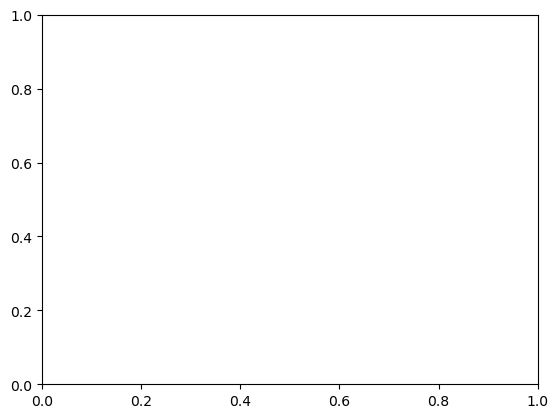

In [151]:
da.plot()

In [127]:
da_standardized_index = calc_standardized_index_daily(da, scale)

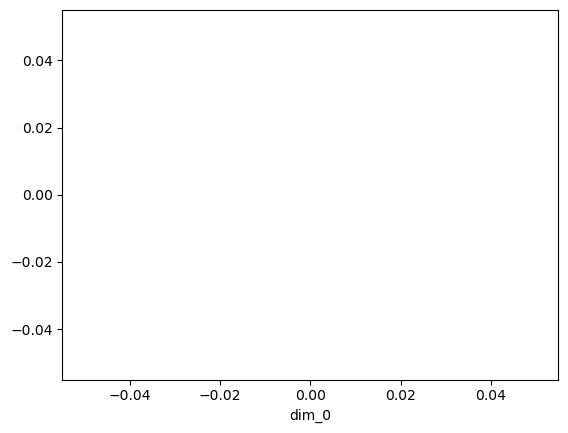

In [128]:
da_standardized_index.plot()

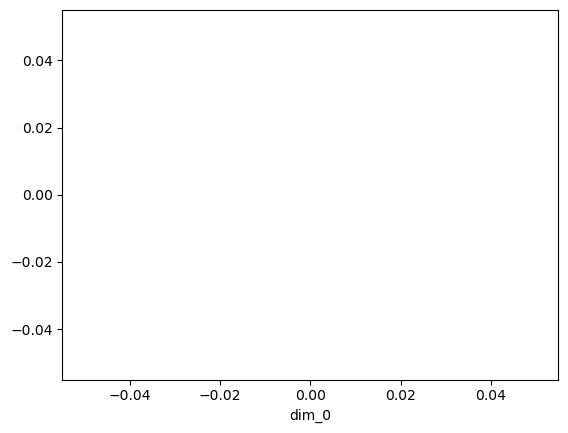

In [93]:
da_standardized_index.plot()

In [129]:
r_da = r_time_series(robjects.FloatVector(da), start = robjects.IntVector([da.time.dt.year[0].values, da.time.dt.month[0].values]), frequency = 365)

In [137]:
da

<xarray.DataArray 'pr' (time: 730)>
dask.array<where, shape=(730,), dtype=float64, chunksize=(365,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2020-01-01 11:00:00 ... 2021-12-31 11:00:00
Attributes:
    units:          mm/day
    area:           Rhine-mean
    ERA5_variable:  tp

In [133]:
r_spei_function = robjects.r['spei']
r_standardized_index = r_spei_function(r_da, scale=scale, na_rm=False, distribution='log-Logistic',verbose=True)

[1] "Calculating the Standardized Precipitation Evapotranspiration Index (SPEI) at a time scale of 7. Using kernel type 'rectangular', with 0 shift. Fitting the data to a log-Logistic distribution. Using the ub-pwm parameter fitting method. Checking for missing values (`NA`): all the data must be complete. Using the whole time series as reference period. Input type is tsvector. Time series spanning Jan 2020 to Dec 2021, with frequency = 365."


In [134]:
r_standardized_index

<rpy2.robjects.vectors.ListVector object at 0x155257050740> [RTYPES.VECSXP]
R classes: ('spei',)
[LangSexpV..., StrSexpVe..., FloatSexp..., BoolSexpV..., ..., ListSexpV..., StrSexpVe..., StrSexpVe..., BoolSexpV...]
  call: <class 'rpy2.rinterface.LangSexpVector'>
  <rpy2.rinterface.LangSexpVector object at 0x15525719cd40> [RTYPES.LANGSXP]
  info: <class 'rpy2.rinterface_lib.sexp.StrSexpVector'>
  <rpy2.rinterface_lib.sexp.StrSexpVector object at 0x1552571f28c0> [RTYPES.STRSXP]
  fitted: <class 'rpy2.rinterface.FloatSexpVector'>
  <rpy2.rinterface.FloatSexpVector object at 0x15525719cd40> [RTYPES.REALSXP]
  coefficients: <class 'rpy2.rinterface.BoolSexpVector'>
  <rpy2.rinterface.BoolSexpVector object at 0x15525719fd80> [RTYPES.LGLSXP]
  scale: <class 'rpy2.rinterface.IntSexpVector'>
  <rpy2.rinterface.IntSexpVector object at 0x15525719cd40> [RTYPES.INTSXP]
  kernel: <class 'rpy2.rinterface.ListSexpVector'>
  <rpy2.rinterface.ListSexpVector object at 0x15525719c680> [RTYPES.VECSXP]
  distribution: <class 'rpy2.rinterface_lib.sexp.StrSexpVector'>
  <rpy2.rinterface_lib.sexp.StrSexpVector object at 0x15525719cd40> [RTYPES.STRSXP]
  fit: <class 'rpy2.rinterface_lib.sexp.StrSexpVector'>
  <rpy2.rinterface_lib.sexp.StrSexpVector object at 0x15525711ca40> [RTYPES.STRSXP]
  na.action: <class 'rpy2.rinterface.BoolSexpVector'>
  <rpy2.rinterface.BoolSexpVector object at 0x15525719e1c0> [RTYPES.LGLSXP]

In [178]:
def calc_standardized_index_daily(da, scale):
    SPEI_package = importr('SPEI')
    r_spei_function = robjects.r['spei']

    # convert to R timeseries
    r_da = r_time_series(robjects.FloatVector(da.values), start = robjects.IntVector([da.time.dt.year[0].values, da.time.dt.month[0].values]), frequency = 365)
    # r_da = r_time_series(robjects.FloatVector(da), start = robjects.IntVector([2000, 1,1]), frequency = 365)
    r_standardized_index = r_spei_function(r_da, scale=scale, na_rm=True, distribution='log-Logistic',verbose=False)
    da_standardized_index = xr.DataArray(pandas2ri.ri2py_vector(r_standardized_index.rx2('fitted')))
    
    return da_standardized_index

In [67]:
def calc_index_to_netcdf(var, diri, basin, scale):

    da = read_in_ERA5(var, diri, basin)
    da_standardized_index = calc_standardized_index_daily(da, scale)

    # define data with variable attributes as Xarray dataset

    if var == 'pr':
        indexname = 'SPI'
    elif var == 'mrsos':
        indexname = 'SMI'
    elif var == 'wb':
        indexname = 'SPEI'
    elif var == 'es':
        indexname = 'ESI'


    var_attr = {'units': '-', 
                        'standard_name': f'{indexname}_{scale}d',
                        'long_name': f'{indexname} standardized index of {var} (scale: {scale}d)'}
    coords={'time': (['time'], da.time.data, da.time.attrs)}
              
    ds_new = xr.Dataset(
    data_vars=dict(
        index=(['time'],  
                      da_standardized_index, 
                       var_attr,
    )),
    coords=coords
    )

    ds_new.to_netcdf(f'{indexname}_test.nc')
    return da_standardized_index,var_attr,coords

    

In [68]:

da_standardized_index,var_attr,coords = calc_index_to_netcdf(var,  diri, 'Rhine', 7)

ValueError: did not find a match in any of xarray's currently installed IO backends ['netcdf4', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html

In [52]:
len(da.time.data)

3653

In [53]:
len(da_standardized_index_7)

3653

In [105]:
da = ds[var].sel(lat=53,lon=5,method='nearest')

In [40]:
da_standardized_index_7 = calc_standardized_index_daily(da, 7)

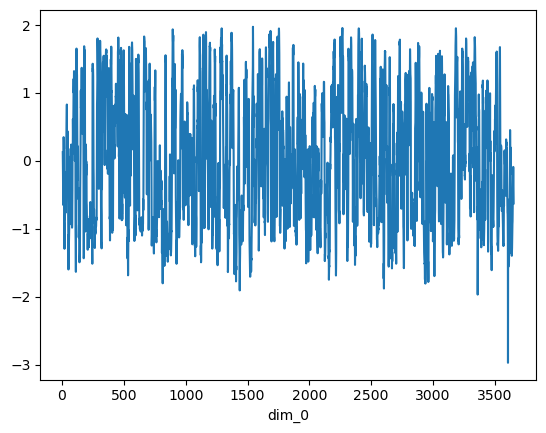

In [41]:
da_standardized_index_7.plot()
# da.plot()

In [ ]:
#          

In [152]:
diri='/perm/nklm/Px_drought/testing/LENTIS/PD/day/'

In [153]:
fili = 'pr/pr_h010.nc'

In [154]:
ds = xr.open_dataset(diri+fili)

In [17]:
var='pr'
ds[var].time.dt.year[0].values

array(2000)

In [155]:
da = ds[var].sel(lat=53,lon=5,method='nearest')

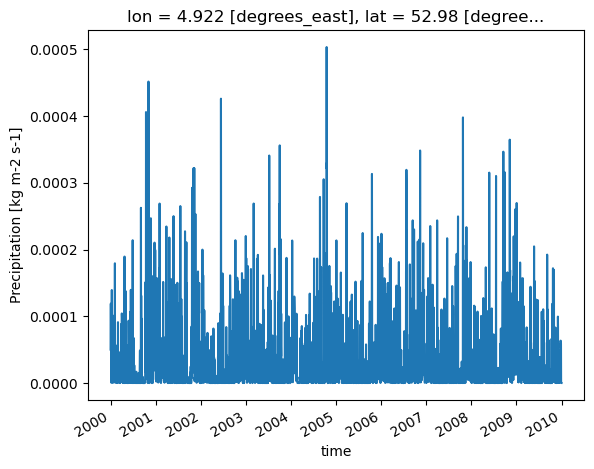

In [146]:
da.plot()

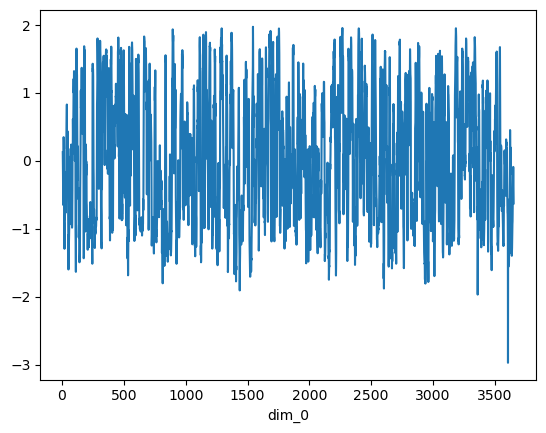

In [145]:
da_standardized_index_7.plot()

In [158]:
da.time

<xarray.DataArray 'time' (time: 3653)>
array(['2000-01-01T12:00:00.000000000', '2000-01-02T12:00:00.000000000',
       '2000-01-03T12:00:00.000000000', ..., '2009-12-29T12:00:00.000000000',
       '2009-12-30T12:00:00.000000000', '2009-12-31T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01T12:00:00 ... 2009-12-31T12:00:00
    lon      float64 4.922
    lat      float64 52.98
Attributes:
    standard_name:  time
    long_name:      time
    bounds:         time_bnds
    axis:           T

In [159]:
import pandas as pd

In [164]:
times = pd.date_range('2022-01-01', periods=365, freq='D')

In [165]:
times

DatetimeIndex(['2022-01-01', '2022-01-02', '2022-01-03', '2022-01-04',
               '2022-01-05', '2022-01-06', '2022-01-07', '2022-01-08',
               '2022-01-09', '2022-01-10',
               ...
               '2022-12-22', '2022-12-23', '2022-12-24', '2022-12-25',
               '2022-12-26', '2022-12-27', '2022-12-28', '2022-12-29',
               '2022-12-30', '2022-12-31'],
              dtype='datetime64[ns]', length=365, freq='D')

In [170]:
ds = xr.open_dataset('/scratch/nkkw/Karin/P2_flashdroughts/meteodata_ERA5/pr_Rhine_2020.nc')

In [171]:
ds.time

<xarray.DataArray 'time' (time: 366)>
array(['2020-01-01T11:00:00.000000000', '2020-01-02T11:00:00.000000000',
       '2020-01-03T11:00:00.000000000', ..., '2020-12-29T11:00:00.000000000',
       '2020-12-30T11:00:00.000000000', '2020-12-31T11:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2020-01-01T11:00:00 ... 2020-12-31T11:00:00

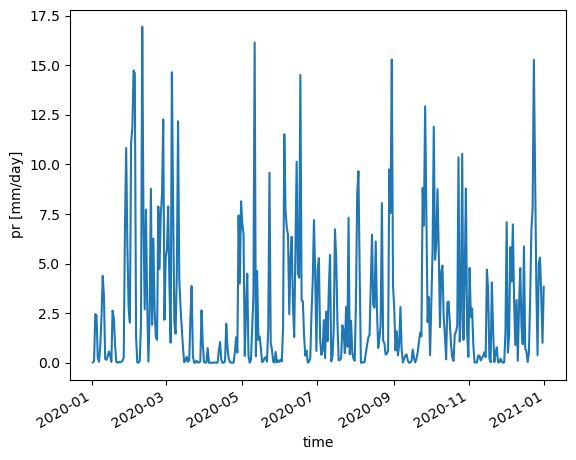

In [172]:
ds['pr'].plot()

In [179]:
da_standardized_index = calc_standardized_index_daily(ds['pr'], 7)

In [180]:
da_standardized_index

<xarray.DataArray (dim_0: 366)>
array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan])
Dimensions without coordinates: dim_0

In [176]:
ds['pr'].time.dt.month[0].values

array(1)

In [181]:
r_da = r_time_series(robjects.FloatVector(ds['pr']), start = robjects.IntVector([ds['pr'].time.dt.year[0].values, ds['pr'].time.dt.month[0].values]), frequency = 365)


In [184]:
r_da

0.012944,0.080848,2.454883,...,3.346687,1.004174,3.831450


In [185]:
r_standardized_index = r_spei_function(r_da, scale=scale, na_rm=True, distribution='log-Logistic',verbose=False)

In [186]:
r_standardized_index

<rpy2.robjects.vectors.ListVector object at 0x155257630d00> [RTYPES.VECSXP]
R classes: ('spei',)
[LangSexpV..., StrSexpVe..., FloatSexp..., BoolSexpV..., ..., ListSexpV..., StrSexpVe..., StrSexpVe..., BoolSexpV...]
  call: <class 'rpy2.rinterface.LangSexpVector'>
  <rpy2.rinterface.LangSexpVector object at 0x155256f7f8c0> [RTYPES.LANGSXP]
  info: <class 'rpy2.rinterface_lib.sexp.StrSexpVector'>
  <rpy2.rinterface_lib.sexp.StrSexpVector object at 0x1552560cf480> [RTYPES.STRSXP]
  fitted: <class 'rpy2.rinterface.FloatSexpVector'>
  <rpy2.rinterface.FloatSexpVector object at 0x1552560cfec0> [RTYPES.REALSXP]
  coefficients: <class 'rpy2.rinterface.BoolSexpVector'>
  <rpy2.rinterface.BoolSexpVector object at 0x1552560cf480> [RTYPES.LGLSXP]
  scale: <class 'rpy2.rinterface.IntSexpVector'>
  <rpy2.rinterface.IntSexpVector object at 0x1552560cfec0> [RTYPES.INTSXP]
  kernel: <class 'rpy2.rinterface.ListSexpVector'>
  <rpy2.rinterface.ListSexpVector object at 0x1552560cf200> [RTYPES.VECSXP]
  distribution: <class 'rpy2.rinterface_lib.sexp.StrSexpVector'>
  <rpy2.rinterface_lib.sexp.StrSexpVector object at 0x1552560cfec0> [RTYPES.STRSXP]
  fit: <class 'rpy2.rinterface_lib.sexp.StrSexpVector'>
  <rpy2.rinterface_lib.sexp.StrSexpVector object at 0x1552560cedc0> [RTYPES.STRSXP]
  na.action: <class 'rpy2.rinterface.BoolSexpVector'>
  <rpy2.rinterface.BoolSexpVector object at 0x1552560cfec0> [RTYPES.LGLSXP]